## CUQIpy component final project

**Note: under construction to be finalized by midnight 21 July 2024** 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# import cuqi
from cuqi.model import Model #, LinearModel
from cuqi.geometry import MappedGeometry, Continuous1D, KLExpansion #, Geometry, Continuous
from cuqi.distribution import Gaussian
from scipy.linalg import lu_factor, lu_solve

from testBeam import BeamModel1D

In [5]:
class hydraulic_class():
    def __init__(self, N, L=1, source_idx=0):
        self.L = L
        self.N = N
        self.x = np.linspace(self.L/self.N,1,self.N)
        self.dx = self.L/self.N
        self.source_idx = source_idx
        self.source()

    def forward(self, a):
        diag1 = -(a[1:] + a[:-1])
        diag1 = np.concatenate([diag1,[-a[-1]]])
        diag2 = a[1:]

        Dxx = np.diag(diag1) + np.diag(diag2,-1) + np.diag(diag2,1)
        Dxx /= self.dx*self.dx

        lu, piv = lu_factor(Dxx)

        sol = lu_solve((lu, piv), self.b_terms) 

        return np.array(sol)

    def source(self, n_source=5, std=0.02):
        dist = self.L/(n_source+1)
        source_coords = np.linspace( dist,self.L-dist, n_source )
        self.b_terms =  np.exp( -0.5*(self.x - source_coords[self.source_idx])**2/std/std )/std/np.sqrt(2*np.pi) 


- Create a mapped KL expansion domain geometry with the mapping `lambda x: exp(x)`.
- Create a continuous range geometry for the range.
- Create a user define CUQIpy model representing the forward model (hydraulic).
- Create a Gaussian i.i.d. prior
- Create a Gaussian likelihood (for one injection pattern)
- Create a synthetic data from the given true porosity.
- Create a posterior
- Use MH for sampling
- Use NUTS for sampling
- Compare the results (ess, pair_plot, trace_plot, plot_ci)
- Comment on the computational cost of nuts (tree size, FD)
- Create a posterior with multiple likelihoods (for multiple injection patterns)
- Use MH for sampling
- Comment on how adding more data helped the inference.



[-0.04938098 -0.09629044 -0.09629044 -0.09629044 -0.09629044 -0.09629044
 -0.09629044 -0.09629044 -0.09629044 -0.09629044]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.79329507e-03
 5.04799737e-05 1.52181334e-04 5.48792483e-03 1.13157645e-04
 2.74418584e-04 8.13495728e-03 1.86324767e-04 3.76659893e-04
 1.07676856e-02 2.68742290e-04 4.63840293e-04 1.34008921e-02
 3.59216620e-04 5.37648517e-04 1.60500595e-02 4.56702277e-04
 5.99141854e-04 1.87329726e-02 5.60267280e-04 6.48821124e-04
 2.14591543e-02 6.68845565e-04 6.86051011e-04 2.42324880e-02
 7.81189183e-04 7.09568179e-04 2.70599736e-02 8.95960347e-04
 7.17875452e-04]
Plotting 5 randomly selected samples


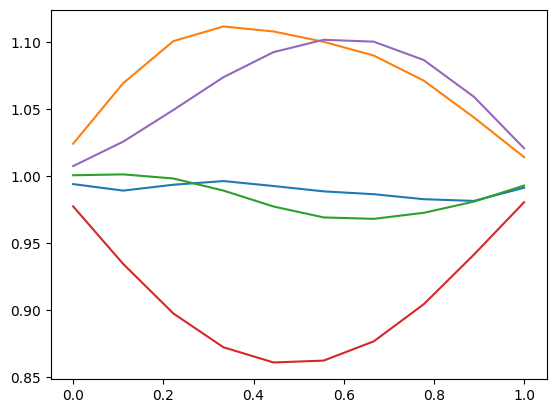

In [6]:
# Data and initialization
t = lambda X: np.exp(X)             # Define mapping
L = 1                               # domain length 1
N_points = 10                       # Number of discretization points
N_modes = 5                         # Number of terms in KL expansion
grid1 = np.linspace(0,L,N_points)   # Discretization for domain

# Create Beam and hydrolic models
model_hydrolic = Model(forward=hydraulic_class(N=N_points, L=L).forward, 
                       range_geometry=Continuous1D(grid=grid1),
                       domain_geometry=MappedGeometry(KLExpansion( grid=grid1,num_modes=N_modes ), map = t))

model_Beam = Model(forward=BeamModel1D(nelx=N_points, Lx=L).forward, 
                   range_geometry=Continuous1D(grid=grid1),
                   domain_geometry=MappedGeometry(KLExpansion(grid=grid1,
                                                              num_modes=N_modes), 
                                                              map = t))


# Test both mdoels for som input
print(model_hydrolic(np.ones(5)))
print(model_Beam(np.ones(5)))

# Gaussian prior -> test it on beam domain
x = Gaussian(0,1,geometry=model_Beam.domain_geometry);
x.sample(100).plot();